### Lesson 3 Assignment: Data Sources
### Lawrence Huang
#### Instructions:

Using the Superstore Transaction dataset, create a new notebook and perform each of the following tasks and answer the related questions:

1. Read dataset
2. Calculate the Recency, Frequency, Monitory for each customer
3. Using K-means algorithm, perform customer segmentation
4. Describe your results


In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##### 1. Read dataset

In [2]:
# Load data: Superstore Transaction dataset
filename = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv'
df = pd.read_csv(filename)
# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


##### 2. Calculate the Recency, Frequency, Monitory for each customer
Strategy: 
<ul>
    <li>Use Order Date (instead of Ship Date) for calcuating the Recency, Frequency, Monetary features</li>
    <li>In order to segment the entire customer base, consider all customers who have placed an order within the time range of the data (i.e. Customers are not dropped because of inactivity)</li>
    <li>Time window for frequency and monetary calcuations: over entire date range</li>
    <li>Set checkpoint as max date in the data</li>
</ul>    

In [3]:
# convert order date to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
# get time range for data
print('Order Date range: {} to {}'.format(df['Order Date'].min().strftime('%Y-%m-%d'), df['Order Date'].max().strftime('%Y-%m-%d')))

Order Date range: 2014-01-03 to 2017-12-30


In [4]:
# set checkpoint as max date in the data
checkpoint = df['Order Date'].max()+pd.DateOffset(days=0)
print('Checkpoint: {}'.format(checkpoint.strftime('%Y-%m-%d')))

Checkpoint: 2017-12-30


In [5]:
# Recency, Frequency, Monetary (RFM) table
rfm = df.groupby(['Customer ID','Customer Name']).agg(
        Recency=('Order Date', lambda x: (checkpoint-x.max()).days),
        Frequency=('Quantity', 'count'),
        Monetary_Value=('Sales', 'sum'),
        Monetary_Quantity=('Quantity', 'sum'),
        Monetary_Profit=('Profit', 'sum')
        )
print('# Customers: {}'.format(rfm.shape[0]))
print('\nRFM for first 5 customers:')
rfm.head()

# Customers: 793

RFM for first 5 customers:


,,Recency,Frequency,Monetary_Value,Monetary_Quantity,Monetary_Profit
Customer ID,Customer Name,,,,,
AA-10315,Alex Avila,184,11,5563.560,30,-362.8825
AA-10375,Allen Armold,19,15,1056.390,41,277.3824
AA-10480,Andrew Allen,259,12,1790.512,36,435.8274
AA-10645,Anna Andreadi,55,18,5086.935,64,857.8033
AB-10015,Aaron Bergman,415,6,886.156,13,129.3465


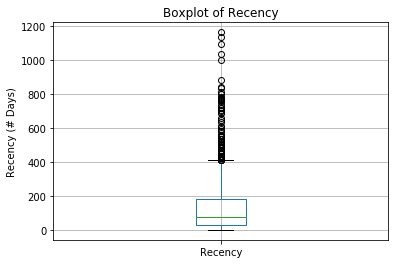

Number of customers who have not placed an order in ~3 years: 3 out of 793


In [6]:
# Examine distribution of Recency
rfm.boxplot(column='Recency')
plt.ylabel('Recency (# Days)')
plt.title('Boxplot of Recency')
plt.show()

# number of customers who haven't placed an order in 3 years (3*365 days)
print('Number of customers who have not placed an order in ~3 years: {} out of {}'.format(np.sum(rfm['Recency']>1095), rfm.shape[0]))   

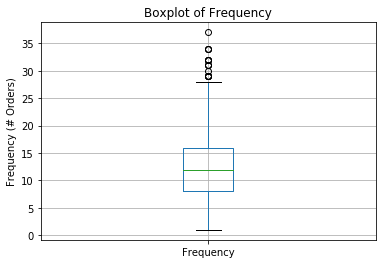

Number of customers with 1 order: 5 out of 793


In [7]:
# Examine distribution of Frequency
rfm.boxplot(column='Frequency')
plt.ylabel('Frequency (# Orders)')
plt.title('Boxplot of Frequency')
plt.show()

# number of customers with 1 order
print('Number of customers with 1 order: {} out of {}'.format(np.sum(rfm['Frequency']==1), rfm.shape[0]))   

Observation: 3 out of 793 customers have not placed an order in 3 years. They could potentially be removed from the customer base to be segmented, if the superstore considers them lost. The frequency feature revealed that most customers are repeat customers.

##### 3. Using K-means algorithm, perform customer segmentation
KMeans on RFM features

In [8]:
# standardize columns (z-score)
X = StandardScaler().fit_transform(rfm.copy())
X = pd.DataFrame(X, columns=rfm.columns)

KMeans on RFM features without Profit

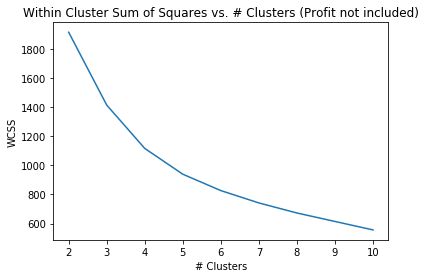

In [9]:
# RFM features without profit
X1 = X[['Recency', 'Frequency', 'Monetary_Value', 'Monetary_Quantity']]

# estimate optimal number of clusters; compare within-cluster sum of squares for a range of number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=5)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Within Cluster Sum of Squares vs. # Clusters (Profit not included)')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
# fit Kmeans to RFM table, using 6 clusters
kmeans = KMeans(n_clusters=6, random_state=5)
kmeans_labels1 = kmeans.fit_predict(X1)

# add the cluster label to the RFM table
rfm['Cluster'] = kmeans_labels1

KMeans on RFM features + Profit

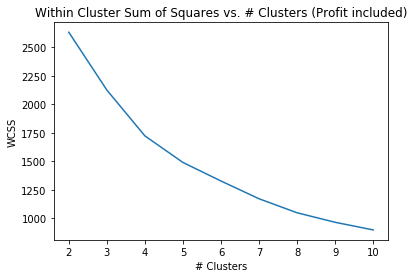

In [11]:
# estimate optimal number of clusters; compare within-cluster sum of squares for a range of number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=5)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Within Cluster Sum of Squares vs. # Clusters (Profit included)')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
# fit Kmeans to RFM table + Profit, using 6 clusters
kmeans = KMeans(n_clusters=6, random_state=5)
kmeans_labels2 = kmeans.fit_predict(X)

# add the cluster label to the RFM table
rfm['Cluster_Profit'] = kmeans_labels2

In [13]:
# resultant RFM table with cluster labels
# Cluster: KMeans label without profit
# Cluster_Profit: KMeans label with profit
print('\nRFM for first 5 customers, with cluster labels:')
rfm.head()


RFM for first 5 customers, with cluster labels:


,,Recency,Frequency,Monetary_Value,Monetary_Quantity,Monetary_Profit,Cluster,Cluster_Profit
Customer ID,Customer Name,,,,,,,
AA-10315,Alex Avila,184,11,5563.560,30,-362.8825,0,0
AA-10375,Allen Armold,19,15,1056.390,41,277.3824,0,2
AA-10480,Andrew Allen,259,12,1790.512,36,435.8274,0,0
AA-10645,Anna Andreadi,55,18,5086.935,64,857.8033,2,2
AB-10015,Aaron Bergman,415,6,886.156,13,129.3465,3,5


##### 4. Describe your results

RFM features were calculated for each customer (see strategy described above), and KMeans clustering was used for customer segmentation. Customers were segmented into 6 clusters, based on the elbow method and within-cluster sum of squares. 

Customer segmentation results are described below:

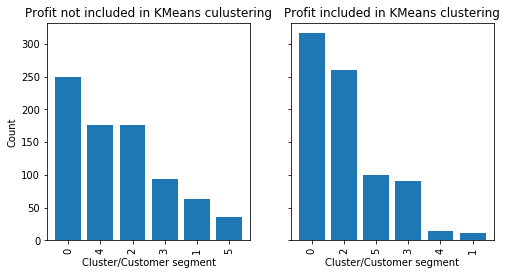

In [14]:
# distribution of clusters/customer segments
fig, axs = plt.subplots(1,2, sharey=True, figsize=(8,4))
rfm['Cluster'].value_counts().plot(kind='bar', width=0.8, ax=axs[0])
axs[0].set_title('Profit not included in KMeans culustering')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Cluster/Customer segment')

rfm['Cluster_Profit'].value_counts().plot(kind='bar', width=0.8, ax=axs[1])
axs[1].set_title('Profit included in KMeans clustering')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Cluster/Customer segment')
plt.show()

Customer segmentation without Profit:
Clusters sorted by Frequency and Monetary average (high to low): [1 5 2 0 3 4]


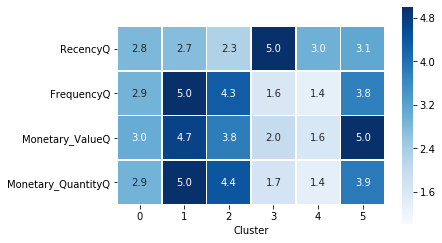

In [15]:
# for easier comparison, convert RFM features to quantiles, and compare the mean between clusters
rfm['RecencyQ'] = pd.qcut(rfm['Recency'].values, 5).codes + 1
rfm['FrequencyQ'] = pd.qcut(rfm['Frequency'].values, 5).codes + 1
rfm['Monetary_ValueQ'] = pd.qcut(rfm['Monetary_Value'].values, 5).codes + 1
rfm['Monetary_QuantityQ'] = pd.qcut(rfm['Monetary_Quantity'].values, 5).codes + 1
rfm['Monetary_ProfitQ'] = pd.qcut(rfm['Monetary_Profit'].values, 5).codes + 1

# clusters without profit
print('Customer segmentation without Profit:')
rfmq = rfm.groupby('Cluster')[['RecencyQ', 'FrequencyQ', 'Monetary_ValueQ', 'Monetary_QuantityQ']].mean()
sns.heatmap(rfmq.T, vmin=1, vmax=5, cmap='Blues', annot=True, fmt='.1f', linewidth=0.5, square=True);

# find clusters with highest mean F and M features
print('Clusters sorted by Frequency and Monetary average (high to low): {}'.format(rfmq.loc[:, ~rfmq.columns.isin(['RecencyQ'])].mean(axis=1).sort_values(ascending=False).index.values))

##### Results from customer segmentation, not using Profit:
From largest cluster to smallest cluster:<br>

<ul>
    <li>Cluster 0: average R, F, MV, MQ</li>
    <li>Cluster 4: average R, low F, MV, MQ</li>
    <li>Cluster 2: average R, high F, MV, MQ</li>
    <li>Cluster 3: max R, low F, MV, MQ</li>
    <li>Cluster 1: average R, max F, high MV, max MQ</li>
    <li>Cluster 5: average R, high F, max MV, high MQ</li>
</ul>
where R: Recency, F: Frequency, MV: Monetary_Value, MQ: Monetary_Quantity

<ul>
    <li>Assuming that the lowest R, highest F and M represent the best customers: Cluster 1 arguably represents the best and Cluster 3 arguably represents the worse.</li>
    <li>Customers with average RFM features make up the largest cluster (Cluster 0), followed by customers with average R but high and low F and M features (tie between Clusters 4 and 2). These 3 clusters make up 76% of the customer base.</li>
    </ul>

Customer segmentation with Profit:
Clusters sorted by Frequency and Monetary average (high to low): [3 4 2 1 0 5]


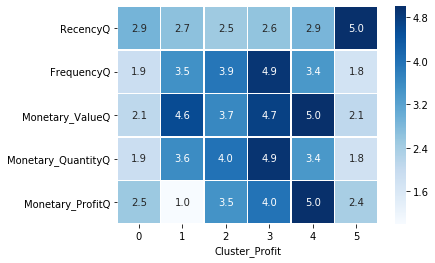

In [16]:
# clusters with profit
print('Customer segmentation with Profit:')
rfmq = rfm.groupby('Cluster_Profit')[['RecencyQ', 'FrequencyQ', 'Monetary_ValueQ', 'Monetary_QuantityQ', 'Monetary_ProfitQ']].mean()
sns.heatmap(rfmq.T, vmin=1, vmax=5, cmap='Blues', annot=True, fmt='.1f', linewidth=0.5, square=True);

# find clusters with highest mean F and M features
print('Clusters sorted by Frequency and Monetary average (high to low): {}'.format(rfmq.loc[:, ~rfmq.columns.isin(['RecencyQ'])].mean(axis=1).sort_values(ascending=False).index.values))

##### Results from customer segmentation using Profit:
From largest cluster to smallest cluster:<br>
<ul>
    <li>Cluster 0: average R, F, MV, MQ, MP</li>
    <li>Cluster 2: average R, high F, MV, MQ, MP</li>
    <li>Cluster 5: max R, low-average F, MV, MQ, MP</li>
    <li>Cluster 3: average R, close to max F, MV, MQ, high MP</li>
    <li>Cluster 4: average R, high F, max MV, high MQ, max MP</li>
    <li>Cluster 1: average R, high F, max MV, MQ, min MP</li>
</ul>
where R: Recency, F: Frequency, MV: Monetary_Value, MQ: Monetary_Quantity, MP: Monetary_Profit

<ul>
    <li>Assuming that the lowest R, highest F and M represent the best customers: Cluster 3 arguably represents the best (or Cluster 4, if profit most important) and Cluster 5 arguably represents the worse.</li>
    <li>Cluster 1 takes advantage of discounts.</li>
    <li>Customers with average RFM features (slightly below average for F, MV, MQ) make up the largest cluster (Cluster 0), followed by customers with average R but above average/high F, MV, MQ, MP (Cluster 2). Cluster 0 and Cluster 2 make up 73% of the customer base.</li>
    </ul>